# DS3000: Summer Olympics Prediction Model

**Group Members**: Khushi Khan, Saanvi Vutukur, Maya Sachidanand, Serena Green 

In [1]:
#importing necessary libraries for assignment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-v0_8-whitegrid')
from scipy import stats
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy import stats

# EDA and Visualization

**Initial Data Reduction**: First, we are going to narrow down the dataset. We will constrict the data to only look at Summer Olympics, and also ensure that we look at recent history by making sure that the year is after 1970. We create a new column, NewMedal to indicate whether the athlete has won a medal or not. This will be important in building our predictive models. 

In [2]:
#reading in a csv file as a dataframe
athlete_df = pd.read_csv('athlete_events.csv')

athlete_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
#only keeping rows in which the season is summer and after 1970
athlete_df = athlete_df[athlete_df['Season'] == 'Summer']
athlete_df = athlete_df[athlete_df['Year'] > 1970]

In [4]:
#make a medal or no medal column 
athlete_df['NewMedal'] = ''

#indicate whether the athlete won a medal (of any type) or not 
for index, item in athlete_df['Medal'].items():
    if item in ['Gold', 'Silver', 'Bronze']:
        athlete_df.loc[index, 'NewMedal'] = 'Medal'
    else:
        athlete_df.loc[index, 'NewMedal'] = 'No Medal'

In [5]:
athlete_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,NewMedal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,No Medal
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,No Medal
31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,Finland,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,NaN,No Medal
32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,Finland,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,NaN,No Medal
33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,Finland,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,NaN,No Medal


**Data Cleaning and Preparation** Next, we will clean the data to remove nulls and invalid values and ensure correct data types. We drop the ID column due to the inherent indexing of Pandas DataFrames, and we also drop duplicate values, since an athlete cannot compete in the same Olympics for the same sport multiple times. 

When handling missing values, we used a combination of imputation and deletion to maintain the robustness and the integrity of the dataset. We imputed the mean age of the dataset for NaN 'Age' values, since most Olympic athletes are in similar age ranges. We imputed 'No Medal' for NaN values in the 'Medal' column, since it is much more likely to not win a medal than to win one. After these steps, the remaining null values were in the 'Height' and 'Weight' columns. Since these features differ greatly based on sport, event, and country, and these values are important for our predictive models, we decided to drop any rows with values missing in these columns. 

We converted the 'Name', 'Team', 'NOC', 'Games', 'City', 'Sport', and 'Event' columns to a string, as they either represented word values in each row and had too many different valuees to be labelled appropriately as a category. 'Sex', 'Season', 'Medal', and 'NewMedal' were converted to the category data type. 'Age' was converted to an int. 

In [6]:
#drop the ID column
athlete_df = athlete_df.drop('ID', axis=1)

In [7]:
#check for null values
athlete_df.isnull().sum()

Name             0
Sex              0
Age            685
Height        6663
Weight        6921
Team             0
NOC              0
Games            0
Year             0
Season           0
City             0
Sport            0
Event            0
Medal       121310
NewMedal         0
dtype: int64

In [8]:
#removing duplicates
athlete_df = athlete_df.drop_duplicates()

In [9]:
#imputation for age and medal 
mean_age = athlete_df['Age'].mean()
athlete_df['Age'] = athlete_df['Age'].fillna(mean_age)

athlete_df['Medal'] = athlete_df['Medal'].fillna('No medal')

print(athlete_df.isnull().sum())

Name           0
Sex            0
Age            0
Height      6663
Weight      6921
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal          0
NewMedal       0
dtype: int64


In [10]:
#drop all other rows with null values
athlete_df = athlete_df.dropna(subset=['Height', 'Weight'])
athlete_df.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,NewMedal
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,No Medal
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,No Medal
31,Jyri Tapani Aalto,M,31.0,172.0,70.0,Finland,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,No medal,No Medal
32,Minna Maarit Aalto,F,30.0,159.0,55.5,Finland,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,No medal,No Medal
33,Minna Maarit Aalto,F,34.0,159.0,55.5,Finland,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,No medal,No Medal


In [11]:
#checking the types of the data
athlete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134439 entries, 0 to 271110
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Name      134439 non-null  object 
 1   Sex       134439 non-null  object 
 2   Age       134439 non-null  float64
 3   Height    134439 non-null  float64
 4   Weight    134439 non-null  float64
 5   Team      134439 non-null  object 
 6   NOC       134439 non-null  object 
 7   Games     134439 non-null  object 
 8   Year      134439 non-null  int64  
 9   Season    134439 non-null  object 
 10  City      134439 non-null  object 
 11  Sport     134439 non-null  object 
 12  Event     134439 non-null  object 
 13  Medal     134439 non-null  object 
 14  NewMedal  134439 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 16.4+ MB


In [12]:
#converting columns to correct types
athlete_df['Name'] = athlete_df['Name'].astype('string')

#organizing the sex into a category
sex_category = pd.CategoricalDtype(categories=['M', 'F'],
                          ordered=False)

athlete_df['Sex'] = athlete_df['Sex'].astype(sex_category)

athlete_df['Age'] = athlete_df['Age'].astype(int)
athlete_df['Team'] = athlete_df['Team'].astype('string')
athlete_df['NOC'] = athlete_df['NOC'].astype('string')
athlete_df['Games'] = athlete_df['Games'].astype('string')

#organizing the seasons into a category
season_category = pd.CategoricalDtype(categories=['Summer', 'Winter'],
                          ordered=False)

athlete_df['Season'] = athlete_df['Season'].astype(season_category)

athlete_df['City'] = athlete_df['City'].astype('string')
athlete_df['Sport'] = athlete_df['Sport'].astype('string')
athlete_df['Event'] = athlete_df['Event'].astype('string')

#organizing the medals into a category
medal_category = pd.CategoricalDtype(categories=['Bronze', 'Silver', 'Gold', 'No medal'],
                          ordered=False)

athlete_df['Medal'] = athlete_df['Medal'].astype(medal_category)

#organizing the NewMedal column into cateogry
athlete_df['NewMedal'] = athlete_df['NewMedal'].astype('category')

athlete_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134439 entries, 0 to 271110
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Name      134439 non-null  string  
 1   Sex       134439 non-null  category
 2   Age       134439 non-null  int64   
 3   Height    134439 non-null  float64 
 4   Weight    134439 non-null  float64 
 5   Team      134439 non-null  string  
 6   NOC       134439 non-null  string  
 7   Games     134439 non-null  string  
 8   Year      134439 non-null  int64   
 9   Season    134439 non-null  category
 10  City      134439 non-null  string  
 11  Sport     134439 non-null  string  
 12  Event     134439 non-null  string  
 13  Medal     134439 non-null  category
 14  NewMedal  134439 non-null  category
dtypes: category(4), float64(2), int64(2), string(7)
memory usage: 12.8 MB


**Data Visualization 1** For our first visualization, we decided to explore the countries that perform the best at the Olympics. We plotted the top 5 countries with the most medals in a bar graph, demonstrating the country and total number of medals they've won since 1972. From this graph, we can see that the United States has won the most medals.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'USA'),
  Text(1, 0, 'GBR'),
  Text(2, 0, 'AUS'),
  Text(3, 0, 'FRA'),
  Text(4, 0, 'CAN')])

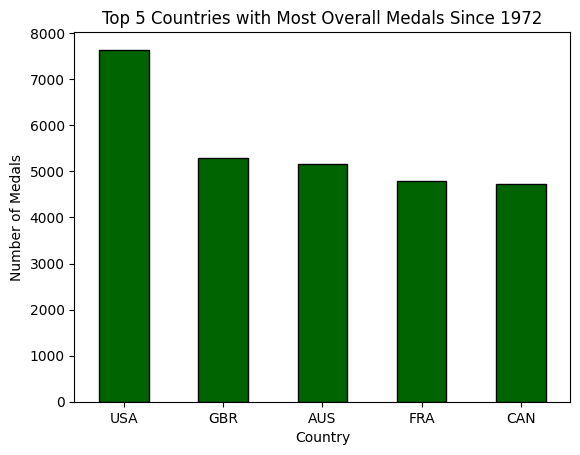

In [13]:
#sort the dataframe by NOC and then the number of medals per NOC
medals_by_country = athlete_df.groupby('NOC')['Medal'].size()

#make the series to be highest number of medals to lowest
sorted_medals_by_country = medals_by_country.sort_values(ascending=False)

#plot the 5 countries with the most medals as a bar graph
sorted_medals_by_country.head(5).plot(kind='bar', color='darkgreen', edgecolor='black')

#set the x axis, y axis, title, and x ticks
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.title('Top 5 Countries with Most Overall Medals Since 1972')
plt.xticks(rotation=0)

**Data Visualization 2** For the next visualization, we explored the number of medals that the US has won since the 1972 Olympics. We plotted the information as a line graph, with data separated by male and female athletes. We added annotations to note important historical events, particularly in relation to gender equality. As we can see, female USA athletes have steadily began winning more medals every year, and even won more medals than male USA athletes in the 2016 Olympics. 

/var/folders/bf/qwdsxm3n4bvfz5355zpjnd2r0000gn/T/ipykernel_46669/990207595.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usa_medals_by_year_gender = us_athletes.groupby(['Year', 'Sex'])['Medal'].size().unstack(fill_value=0)


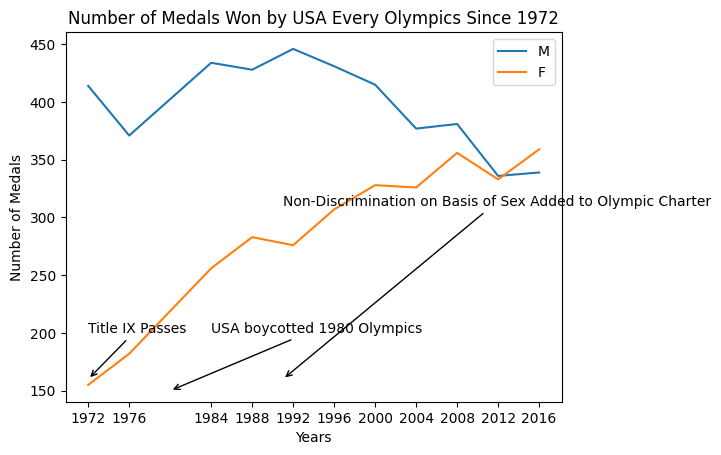

In [14]:
#filter data frame to only include USA athletes
us_athletes = athlete_df[athlete_df['Team'] == 'United States']

#group by year and gender and count medals won each year for each gender
usa_medals_by_year_gender = us_athletes.groupby(['Year', 'Sex'])['Medal'].size().unstack(fill_value=0)

#plot the medals over time as a line chart for each gender
plt.plot(usa_medals_by_year_gender.index, usa_medals_by_year_gender['M'], label='M')
plt.plot(usa_medals_by_year_gender.index, usa_medals_by_year_gender['F'], label='F')

#set the x axis, y axis, title, and x ticks
plt.xlabel('Years')
plt.ylabel('Number of Medals')
plt.title('Number of Medals Won by USA Every Olympics Since 1972')
plt.xticks(usa_medals_by_year_gender.index)

#annotate the graph to describe why 1980 is missing
plt.annotate(f'USA boycotted 1980 Olympics', xy=(1980, 150), 
             xytext = (1984, 200), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))

#annotate the rise in women's medals 
plt.annotate(f'Title IX Passes', xy=(1972, 160), 
             xytext = (1972, 200), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))

#annotate the rise in women's medals 
plt.annotate(f'Non-Discrimination on Basis of Sex Added to Olympic Charter', xy=(1991, 160), 
             xytext = (1991, 310), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))



#add a legend
plt.legend()

#show the plot
plt.show()

**Data Visualization 3** In this clustered bar chart, we explored what proportion of USA female and male athletes won gold, silver, and bronze medals. Female athletes tend to win fewer medals across all three medal types. 

/var/folders/bf/qwdsxm3n4bvfz5355zpjnd2r0000gn/T/ipykernel_46669/815929402.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medal_counts_sex = us_athletes.groupby(['Sex', 'Medal']).size().unstack(fill_value=0)


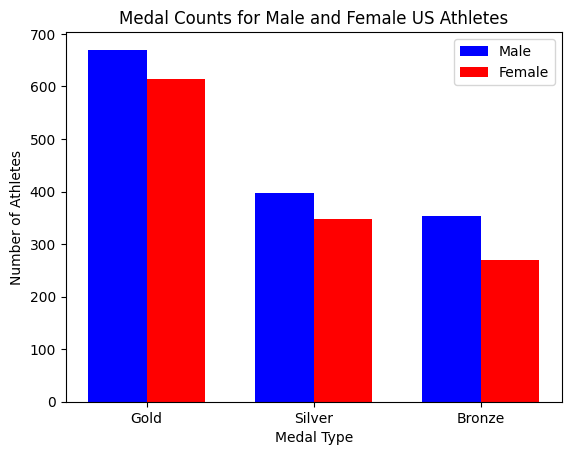

In [15]:
# group the filtered DataFrame by sex and count the number of medals won by each sex
medal_counts_sex = us_athletes.groupby(['Sex', 'Medal']).size().unstack(fill_value=0)

categories = ["Gold", "Silver", "Bronze"]

# extract the counts for each category for male and female athletes
male_counts = medal_counts_sex.loc['M', categories].values
female_counts = medal_counts_sex.loc['F', categories].values


# sets positions of bar width 
bar_width = 0.35
male_positions = np.arange(len(categories))
female_positions = male_positions + bar_width

# create clustered bar graph
# plot bars for male athletes
plt.bar(male_positions, male_counts, label='Male', color='blue', width=bar_width)

# plot bars for female athletes next to male bars
plt.bar(female_positions, female_counts, label='Female', color='red', width=bar_width)

#set the x-axis, y-axis, title, x-ticks, and legend
plt.title('Medal Counts for Male and Female US Athletes')
plt.xlabel('Medal Type')
plt.ylabel('Number of Athletes')
plt.xticks(male_positions + bar_width / 2, categories)  # Set x-ticks at the center of each cluster
plt.legend()

**Data Visualization 4** As a group of all women, we were interested in diving deeper into USA women's sports. In this visualization, we created a bar chart with the top 5 sports that USA female athletes win medals in. USA women's swimming team wins the most medals, followed by athletics, basketball, gymnastics, and rowing. 

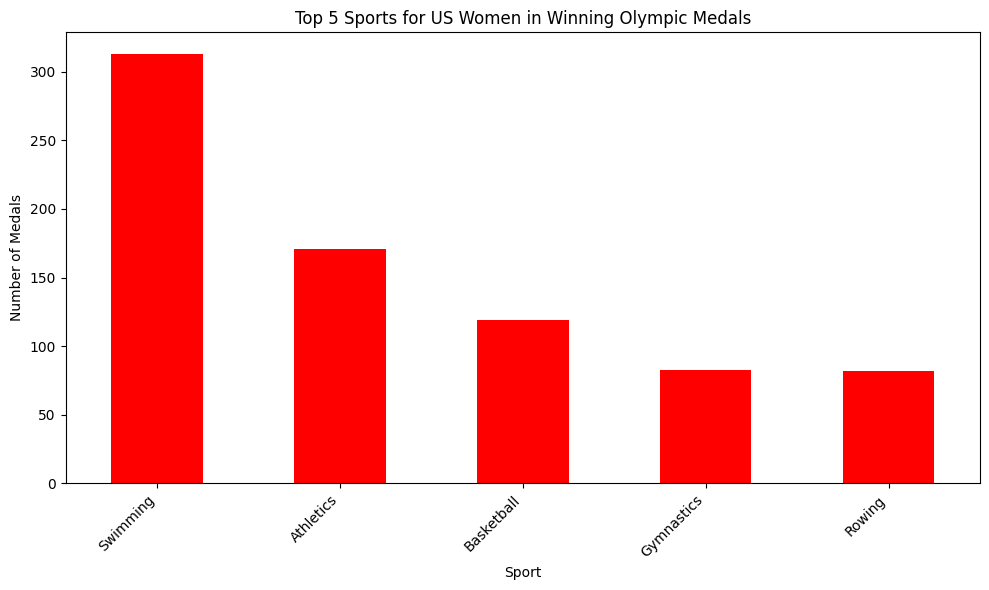

In [16]:
us_female_athletes = us_athletes[us_athletes['Sex'] == 'F']
us_fmedalists = us_female_athletes[us_female_athletes['Medal'] != 'No medal']

# Count the occurrences of each sport
top_sports_us_women = us_fmedalists['Sport'].value_counts().head(5)

# Create a bar plot
plt.figure(figsize=(10, 6))
top_sports_us_women.plot(kind='bar', color='red')
plt.title('Top 5 Sports for US Women in Winning Olympic Medals')
plt.xlabel('Sport')
plt.ylabel('Number of Medals')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Data Visualization 5** For our project, we finally decided to look into USA women's gymnastics. Though swimming and athletics won more medals, we realized that their wide variety of events and team contests may cause difficulty in building a model around. Basketball was also ahead of gymnastics in our previous visualization, but the USA women's basketball team has always medalled, which is not significant or interesting for our model goals. Here, we visualized a scatter plot comparing the heights and weights of female gymnasts to determine if there was any correlation between the features. As we can see, as the weight of the athlete increases, their height increases as well, creating a positive relationship. 

In [17]:
#look at gymnastics athletes
gym = us_female_athletes[us_female_athletes['Sport'] == "Gymnastics"]

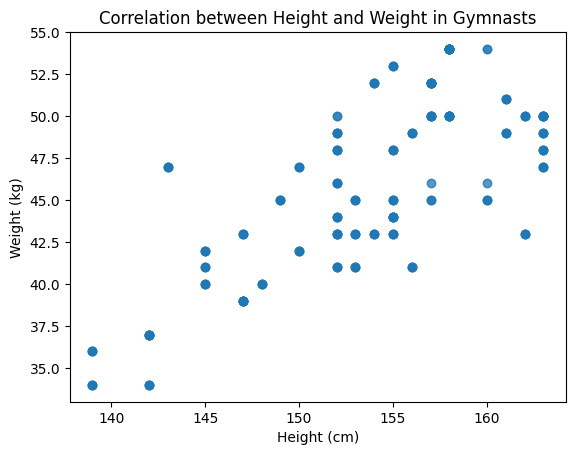

In [18]:
# make a scatter plot showing height and weight correlation in gymnastics 
plt.scatter(gym['Height'], gym['Weight'], alpha=0.5)

plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.title('Correlation between Height and Weight in Gymnasts')


plt.show()

**Statistical Analysis** We were interested in exploring whether the heights of medaling gymnasts differed between gold medalists and silver medalists. We performed a t-test, and set a significance level of 0.05. The p-value of the t-test was 0.44, which is greater than 0.5. Therefore, there is no significant difference between the heights of gold medal gymnasts and silver medal gymnasts. 

In [19]:
#filter to silver and bronze medalists
silver_medalists = gym[gym['Medal'] == 'Gold']
bronze_medalists = gym[gym['Medal'] == 'Silver']

#extract height data
height_silver = silver_medalists['Height']
height_bronze = bronze_medalists['Height']

#perform t-test
t_stat, p_value = stats.ttest_ind(height_silver.dropna(), height_bronze.dropna())

#define significance level
alpha = 0.05

print("p value:", p_value)

#check if p-value is less than alpha
if p_value < alpha:
    print("The difference in height between Gold and Silver medalists is statistically significant.")
else:
    print("There is no statistically significant difference in height between Gold and Silver medalists.")

p value: 0.44313414923541594
There is no statistically significant difference in height between Gold and Silver medalists.


## Adding GDP + Cleaning
We were interested in observing the trend of GDP over the time period we were looking at. We merged a GDP dataset with our Olympic data set to demonstrate the GDP of the athlete's country in the year that they competed. 

In [20]:
# Read the GDP data
gdp_df = pd.read_csv('total_gdp.csv')

# Drop unnecessary columns
gdp_df.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True)

# Melt the DataFrame to transform the year columns into rows
gdp_df_melted = gdp_df.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP')

# Rename the 'Country Name' column to 'Team' to match athlete_df
gdp_df_melted.rename(columns={'Country Name': 'Team'}, inplace=True)

# Convert 'Year' column to numeric (remove non-numeric characters)
gdp_df_melted['Year'] = gdp_df_melted['Year'].str.extract('(\d+)', expand=False).astype(float)

# Drop rows with missing GDP values
gdp_df_melted.dropna(subset=['GDP'], inplace=True)

# Filter the athlete DataFrame to remove teams with numbers
filtered_athlete_df = athlete_df[~athlete_df['Team'].str.contains('\d')]

# Merge the athlete DataFrame with the melted GDP DataFrame
merged_gdp_df = pd.merge(filtered_athlete_df, gdp_df_melted, on=['Team', 'Year'], how='left')

# Add a new column for GDP
merged_gdp_df['GDP'] = merged_gdp_df['GDP'].astype(float)

# Display the merged DataFrame
merged_gdp_df.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,NewMedal,Country Code,GDP
0,A Dijiang,M,24,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal,No Medal,CHN,4.931370e+11
1,A Lamusi,M,23,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal,No Medal,CHN,8.532185e+12
2,Jyri Tapani Aalto,M,31,172.0,70.0,Finland,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,No medal,No Medal,FIN,1.260195e+11
3,Minna Maarit Aalto,F,30,159.0,55.5,Finland,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,No medal,No Medal,FIN,1.321292e+11
4,Minna Maarit Aalto,F,34,159.0,55.5,Finland,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,No medal,No Medal,FIN,1.260195e+11


**USA GDP** We specifically wanted to see if there was any trend between USA GDP and medal counts. As we saw from Data Visualization 2, USA medal counts have been increasing from 1972. From this visualization, we can see that GDP has also been increasing over that time span. We hypothesize that as the American economy strengthens, there is likely more effort to fund and invest in the training of athletes, leading to better Olympic results. 

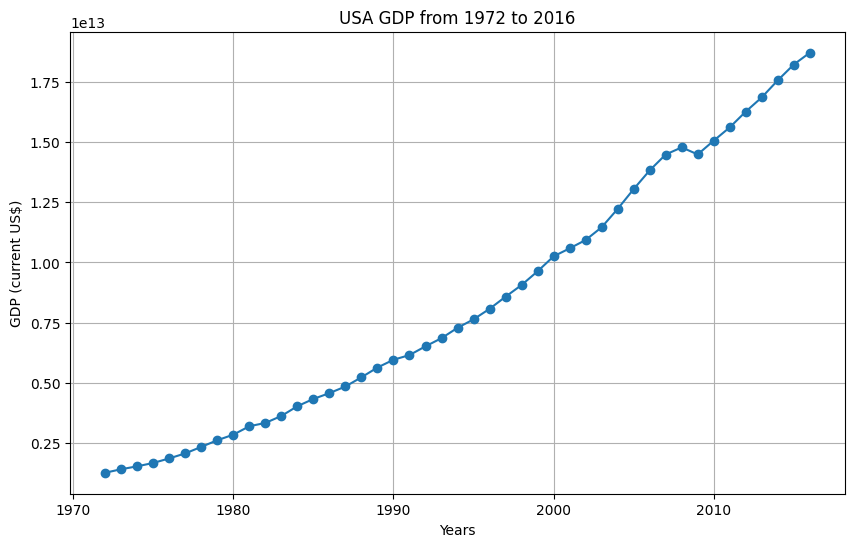

In [21]:
# Sort the data frame to only show USA GDP data
usa_gdp = gdp_df[gdp_df['Country Name'] == 'United States']

# Filter the GDP data for the years 1972 to 2016
usa_gdp = usa_gdp.loc[:, '1972':'2016']

# Extract the years as the index
usa_gdp_years = usa_gdp.columns.astype(int)

# Extract the GDP values for the USA
usa_gdp_values = usa_gdp.iloc[0].values

# Plot the GDP over time as a line chart
plt.figure(figsize=(10, 6))
plt.plot(usa_gdp_years, usa_gdp_values, marker='o', linestyle='-')

# Set the x-axis, y-axis, and title
plt.xlabel('Years')
plt.ylabel('GDP (current US$)')
plt.title('USA GDP from 1972 to 2016')

# Show the plot
plt.grid(True)
plt.show()

# Models

To determine the useulness of our predictor features in the models, we created a correlation matrix, and corresponding heatmap for the features 'Height', 'Weight', and 'Age'. As we can see, the strongest correlation for USA women's gymnastics among these features is between 'Height' and 'Weight', at 0.74. However, as the correlations between 'Weight' and 'Age', as well as 'Height' and 'Age' were both also above 0.1, we decided to include all three features in our models. 

Text(0.5, 1.0, 'Heatmap of Features for Models')

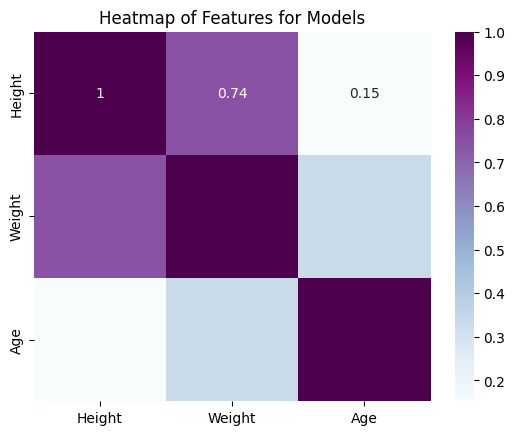

In [22]:
#features to try using 
features_list = ['Height', 'Weight', 'Age']

#creating correlation matrix
corrmat = gym[features_list].corr()
top_corr_features = corrmat.index

#plot the correlation matrix
sns.heatmap(gym[top_corr_features].corr(), annot=True, cmap='BuPu')
plt.title('Heatmap of Features for Models')

### KNeighborsClassifier

**KNN Algorithm** The first model we decided to implement was KNeighborsClassifier, which utilizes the KNN algorithm. We chose a classification model since we have a classification task (deciding whether an athlete will earn a medal or not). 

We tested a range of k values from 1 to 25. We then split the data into a training set (70%) and a test set (30%), with the sets reproducible and stratified. The accuracy of k-values in the model was then plotted in a line graph; k=5 was found to be the most accurate value. 

A classification report was printed that reported 0.56 precision for predicting 'Medal' and a 0.78 precision for predicting 'No Medal'. The macro average accuracy was 0.67, and the weighted average accuracy was 0.73. This was a moderately accurate model.

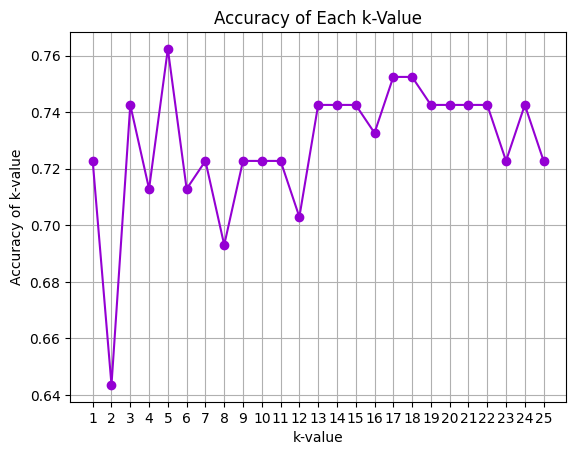

In [23]:
features_list = ['Height', 'Weight', 'Age']

X    = gym[features_list] #the observations
y    = gym['NewMedal'] #the label

#defining a range of k_values that i want to test the accuracy of
k_values = range(1, 26)

#will store accuracies 
accuracies = []

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split( 
                                        X,
                                        y,
                                        test_size=0.3,
                                        random_state=7,
                                        stratify=y
                                        ) 

for k in k_values:
    #build the k-nn model, experiment with different values of k and plot the results
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    #predict the labels for the test set
    y_pred = knn.predict(X_test)
    
    #calculate the accuracy of each of the k values and append it to the accuracies list 
    k_value_accuracy = knn.score(X_test, y_test)
    accuracies.append(k_value_accuracy)
    
#plotting the graph of k-value
plt.plot(k_values, accuracies, marker='o', color='darkviolet')
plt.title('Accuracy of Each k-Value')
plt.xlabel('k-value')
plt.ylabel('Accuracy of k-value')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [24]:
#creating instance of knn model with the highest k_value, 4
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
    
#predict the labels for the test set
y_pred = knn.predict(X_test)
    
#calculate the accuracy of each of the k values and append it to the accuracies list 
k_value_accuracy = knn.score(X_test, y_test)
accuracies.append(k_value_accuracy)

In [25]:
#the target names
target_names = ['Medal', 'No medal']

#creating classification report
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

       Medal       0.56      0.20      0.29        25
    No medal       0.78      0.95      0.86        76

    accuracy                           0.76       101
   macro avg       0.67      0.57      0.58       101
weighted avg       0.73      0.76      0.72       101



**KNN Hyper-Parameter Tuning** We utilized Grid Search to find the optimal hyper-parameters for our model. We specifically looked at the 'n_neighbors', 'weights', 'p', and 'n_jobs' parameters. The 'n_neighbors' parameter determines how many neighbors to consider in the algorithm, while the 'weights' parameter determines whether points should be weighted equally or by their distance. The 'p' parameter decides whether the model should use Manhattan distance or Euclidean distance, while the 'n_jobs' parameter decides the number of jobs that should be run at the same time in the search for neighbors. We cross validated the results 8 times. Ultimately, our best parameters were: n_jobs = -1, n_neighbors = 7, p = 2 (Euclidean), weights = uniform. This gave our model an accuracy of ~0.82, much better than our original score. 

In [26]:
#setup the parameter grid to try values of c ranging from 1 to 10, and the gamma value being either scale or auto
params = {'n_neighbors': np.arange(1, 10), 'weights': ['uniform', 'distance'], 'p': [1, 2], 'n_jobs': [-1, 1]}

knn = KNeighborsClassifier(n_neighbors=5)

#initialize Grid Search with Cross Validation, return the best parameters and score
knn_grid = GridSearchCV(estimator=knn, param_grid=params, cv=8, return_train_score=True)
knn_grid.fit(X_train, y_train)

print('Best parameters:', knn_grid.best_params_)
print('Best score:', knn_grid.best_score_)

Best parameters: {'n_jobs': -1, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Best score: 0.8172413793103448


### RandomForestClassifier

**Random Forest Classification** Similarly to our previous model, we chose another classification model in RandomForestClassifier. We kept the same features, and split the data the same way. We trained the model using the parameters 'n_estimators' = 10, and 'random_state' = 7. The classification report demonstrated a 0.50 precision in predicting 'Medal', and a 0.80 precision at predicting 'No Medal'. The macro average accuracy was 0.65, and the weighted average accuracy was 0.73. These values are similar to those from our KNN classification report. 

In [27]:
X = gym[['Height', 'Weight', 'Age']]
y = gym['NewMedal']

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   ) 

#set the classifier model, train it, and predict the test set
rf = RandomForestClassifier(n_estimators = 10, random_state = 7)
rf.fit(X_train, y_train) 
y_pred = rf.predict(X_test)

#prediction accuracy
print('The accuracy of the model is: {}'.format(rf.score(X_test, y_test))) #get the classification report for the decision tree
y_pred = rf.predict(X_test)

target_names = ['Medal', 'No Medal']
print(classification_report(y_test, y_pred, target_names = target_names))

The accuracy of the model is: 0.7524752475247525
              precision    recall  f1-score   support

       Medal       0.50      0.32      0.39        25
    No Medal       0.80      0.89      0.84        76

    accuracy                           0.75       101
   macro avg       0.65      0.61      0.62       101
weighted avg       0.73      0.75      0.73       101



**Random Forest Hyper-Parameter Tuning** Once again we utilized Grid Search to tune our model. This time, we used the parameters 'max_depth', 'n_estimators', 'max_features', 'min_samples_leaf', and 'min_samples_split'. 'Max_depth' controls the depth of each decision tree in the forest, while 'n_estimators' describes the number of trees in the forest. 'Max_features' represents the maximum number of features that the model should split its nodes into. 'Min_samples_leaf' and 'min_samples_split' both work against overfitting the data by defining the minimum amount of samples required to be at a node or to split at a node. We cross validated our model 5 times. The best hyper-parameters we got were: 'max_depth' = 3, 'max_features' = 1, 'min_samples_leaf' = 4, 'min_samples_split' = 2, 'n_estimators' = 10. This gave our model a score of ~0.76. This tuned model did not give us a higher score than our tuned KNN model. 

In [35]:
#random forest Grid Search
params = {'max_depth':[3, 5, 10, None],
          'n_estimators':[10, 50, 100],
          'max_features':[1, 3, 5, 7],
          'min_samples_leaf':[4, 5, 6],
          'min_samples_split':[2, 3, 4, 5]}

# this was the best score we could get from these parameters, should we lower the amount of n_estimators          
grid = GridSearchCV(rf, param_grid=params, cv=5, scoring='accuracy')
model_grid = grid.fit(X,y)

# grid search results
print('Best grid search hyperparameters are: '+ str(model_grid.best_params_))
print('Best grid search score is: '+ str(model_grid.best_score_))

Best grid search hyperparameters are: {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}
Best grid search score is: 0.758955223880597


### Support Vector Machine Classifier

**SVM** The last model that we implemented was a Support Vector Machine Classifier. We used the same features as the other models, and split the data in the same way. We scaled the numerical data of the training and test set as is appropriate for support vector models. The accurancy of the model was 0.75, similar to the values from the previous models. 

In [29]:
X    = gym[features_list] #the observations
y    = gym['NewMedal'] #the label

#split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

#scale the numerical training data
scaler = StandardScaler()
scaler.fit(X_train[['Height', 'Weight', 'Age']])
X_train[['Height', 'Weight', 'Age']] = scaler.transform(X_train[['Height', 'Weight', 'Age']]) 

In [34]:
#set the svm model, train it
svm = SVC()
svm.fit(X_train, y_train) 

#scale the numerical test data
X_test[['Height', 'Weight', 'Age']] = scaler.transform(X_test[['Height', 'Weight', 'Age']]) 

#predict the test set, print the accuracy of the model
y_pred   = svm.predict(X_test)
target_names = ['Medal', 'No Medal']
print('The accuracy of the model is: {}'.format(svm.score(X_test, y_test)))

The accuracy of the model is: 0.7524752475247525


**SVM Hyper-Parameter Tuning** We again used Grid Search to tune our model. For SVC, we utilized the parameters 'C' and 'gamma'. The 'C' parameter balances the model between the complexity of decision boundaries and low errors on the training set. We cross validated 5 times. The 'gamma' parameter decides the complexity of the decision boundaries. The best parameters for the model were determined to be: 'C' = 30, 'gamma' = 20. The score for this model was ~0.80. This is higher than our Random Forest model, but not quite as high as our KNN model. We also compared the accuracy of the model on the training set versus on the test set. The training set score was 0.85, while the test set score was 0.76. The training set score is higher, suggesting that there might be a bit of overfitting. 

In [31]:
#setup the parameter grid to try values of c ranging from 30 to 35, and values for gamma ranging from 20 to 25.
params = {'C': np.arange(30, 35),
         'gamma': np.arange(20, 25)}

svm = SVC()

#initialize grid search with cross validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5)
svm_grid.fit(X_train, y_train)

print("The best parameters", svm_grid.best_params_) #print the best parameters
print("The best score", svm_grid.best_score_)  #print the best score

The best parameters {'C': 30, 'gamma': 20}
The best score 0.7957446808510638


In [32]:
#evaluate the scores on the training set
train_score = svm_grid.score(X_train, y_train)
print("Training Set Score:", train_score)

#evaluate scores on the test set
test_score = svm_grid.score(X_test, y_test)
print("Test Set Score:", test_score)

Training Set Score: 0.851063829787234
Test Set Score: 0.7623762376237624
